# Fully Bayesian inference for generalized GP models with HMC

*James Hensman, 2015-16*

Converted to candlegp *Thomas Viehmann*

It's possible to construct a very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable since the likelihoods is not generally conjugate to the Gaussian process. The general form of the model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function-values and the parameters $\theta$ jointly. Key to an effective scheme is rotation of the field using the Cholesky decomposition. We write

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over v and the function values is not widely adopted in the literature becate of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in tensorflow, and so application of HMC is relatively straightforward. 

### Exponential Regression example
The first illustration in this notebook is 'Exponential Regression'. The model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. first, generate a data set.

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

import candlegp
import candlegp.training.hmc
import numpy
import torch
from torch.autograd import Variable
from matplotlib import pyplot
pyplot.style.use('ggplot')
%matplotlib inline


X = Variable(torch.linspace(-3,3,20,out=torch.DoubleTensor()))
Y = Variable(torch.from_numpy(numpy.random.exponential(((X.data.sin())**2).numpy())))

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [2]:
#build the model
k = candlegp.kernels.Matern32(1,ARD=False).double() + candlegp.kernels.Bias(1).double()
l = candlegp.likelihoods.Exponential()
m = candlegp.models.GPMC(X[:,None], Y[:,None], k, l)
m

Parameter,Value,Prior,ParamType
V,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 0.99999996],None,PositiveParam
kern.kern_list.0.lengthscales,[ 0.99999996],None,PositiveParam
kern.kern_list.1.variance,[ 0.99999996],None,PositiveParam


The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration). 

In [3]:
m.kern.kern_list[0].lengthscales.prior = candlegp.priors.Gamma(1., 1., ttype=torch.DoubleTensor)
m.kern.kern_list[0].variance.prior = candlegp.priors.Gamma(1.,1., ttype=torch.DoubleTensor)
m.kern.kern_list[1].variance.prior = candlegp.priors.Gamma(1.,1., ttype=torch.DoubleTensor)
m.V.prior = candlegp.priors.Gaussian(0.,1., ttype=torch.DoubleTensor)
m

Parameter,Value,Prior,ParamType
V,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.0.lengthscales,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.1.variance,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam


Running HMC is as easy as hitting m.sample(). GPflow only has HMC sampling for the moment, and it's a relatively vanilla implementation (no NUTS, for example). There are two setting to tune, the step size (epsilon) and the maximum noumber of steps Lmax. Each proposal will take a random number of steps between 1 and Lmax, each of length epsilon. 

We'll use the `verbose` setting so that we can see the acceptance rate.

In [4]:
# start near MAP
opt = torch.optim.LBFGS(m.parameters(), lr=1e-2, max_iter=40)
def eval_model():
    obj = m()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(50):
    obj = m()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.data[0])
m


0 : 32.13378511489978
5 : 12.579152806043249
10 : 12.35091339422903
15 : 12.347333683446855
20 : 12.34728386831572
25 : 12.347283258834006
30 : 12.347283254309534
35 : 12.347283250227553
40 : 12.34728324654416
45 : 12.34728324321992


Parameter,Value,Prior,ParamType
V,[[-1.68599171] [-0.1940676 ] [-0.02834517] [-0.60851289] [ 0.73162335] [-0.5141174 ] [ 0.04072527] [-0.01327125] [-1.5136682 ] [-1.4095951 ] [-0.14044206] [ 0.63296749] [-0.11095845] [-0.98583702] [ 0.61990596] [ 0.53294504] [ 0.92451918] [-0.15306658] [-0.46426236] [-0.42094161]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 4.98986731],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.0.lengthscales,[ 0.22243836],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.1.variance,[ 1.3529125],"Ga([ 1.],[ 1.])",PositiveParam


In [5]:
res = candlegp.training.hmc.hmc_sample(m,500,0.2,burn=50, thin=10)

In [6]:
xtest = torch.linspace(-4,4,100).double().unsqueeze(1)

f_samples = []
for i in range(len(res[0])):
    for j,mp in enumerate(m.parameters()):
        mp.set(res[j+1][i])
    f_samples.append(m.predict_f_samples(Variable(xtest), 5).squeeze(0).t())
f_samples = torch.cat(f_samples, dim=0)


(-0.1, 6.8656001318481055)

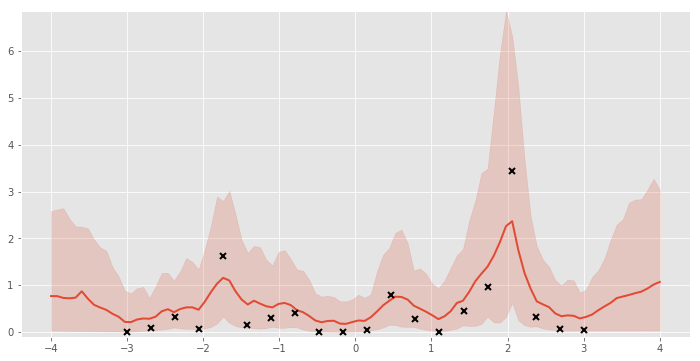

In [7]:
rate_samples = torch.exp(f_samples)
pyplot.figure(figsize=(12, 6))
line, = pyplot.plot(xtest.numpy(), rate_samples.data.mean(0).numpy(), lw=2)
pyplot.fill_between(xtest[:,0], numpy.percentile(rate_samples.data.numpy(), 5, axis=0), numpy.percentile(rate_samples.data.numpy(), 95, axis=0), color=line.get_color(), alpha = 0.2)
pyplot.plot(X.data.numpy(), Y.data.numpy(), 'kx', mew=2)
pyplot.ylim(-0.1, numpy.max(numpy.percentile(rate_samples.data.numpy(), 95, axis=0)))

In [8]:
import pandas
df = pandas.DataFrame(res[1:],index=[n for n,p in m.named_parameters()]).transpose()
df[:10]

,V,kern.kern_list.0.variance,kern.kern_list.0.lengthscales,kern.kern_list.1.variance
0,"[[-1.6831007238686686], [1.3016361375690897], ...",[4.6556942698627815],[0.4643887295158395],[0.3671294119229616]
1,"[[-2.0937727270340103], [1.6710961014838948], ...",[3.764495967071015],[0.5517908322336966],[0.3250583247922273]
2,"[[-2.363504534992662], [1.9710144582213578], [...",[4.1949465903774605],[0.7766699449298291],[0.1581414113421619]
3,"[[-1.0077160084244063], [0.5019987155287693], ...",[2.9652991293902904],[0.5176796791378486],[0.26505871137309006]
4,"[[0.2579770772616268], [-0.5869206188305681], ...",[1.7609108210509203],[0.22965354650828013],[0.8340661951270663]
5,"[[-1.3583174439898962], [-0.6263895048388393],...",[1.6299249852864743],[0.3232539860155341],[0.6524981180201418]
6,"[[-2.2854446527527394], [-1.1434034368923665],...",[1.5217575897320286],[0.14653953794263117],[0.8992657762036006]
7,"[[-1.3852636912138412], [-1.3012770340499658],...",[2.398039418756328],[0.13214371202087305],[0.3770082619934619]
8,"[[-1.3543026720845852], [-1.8791146753496466],...",[1.7631525816806837],[0.17526066377973393],[0.44630329214149916]
9,"[[0.34121948468824115], [-2.500239686962764], ...",[1.1205214360297362],[0.0630071206916623],[0.5079278863205233]


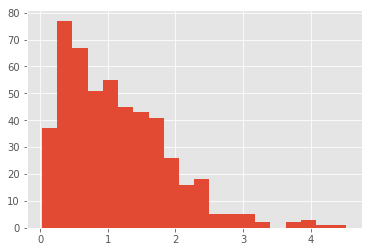

In [9]:
df["kern.kern_list.1.variance"].apply(lambda x: x[0]).hist(bins=20)

# Sparse Version
Do the same with sparse:

In [64]:
Z = torch.linspace(-3,3,5).double().unsqueeze(1)
k2 = candlegp.kernels.Matern32(1,ARD=False).double() + candlegp.kernels.Bias(1).double()
l2 = candlegp.likelihoods.Exponential()
m2 = candlegp.models.SGPMC(X[:,None], Y[:,None], k2, l2, Z)
m2.kern.kern_list[0].lengthscales.prior = candlegp.priors.Gamma(1., 1., ttype=torch.DoubleTensor)
m2.kern.kern_list[0].variance.prior = candlegp.priors.Gamma(1.,1., ttype=torch.DoubleTensor)
m2.kern.kern_list[1].variance.prior = candlegp.priors.Gamma(1.,1., ttype=torch.DoubleTensor)
m2.V.prior = candlegp.priors.Gaussian(0.,1., ttype=torch.DoubleTensor)
m2

Parameter,Value,Prior,ParamType
Z,[[-3. ] [-1.5] [ 0. ] [ 1.5] [ 3. ]],None,Param
V,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.0.lengthscales,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.1.variance,[ 0.99999996],"Ga([ 1.],[ 1.])",PositiveParam


In [66]:
# start near MAP
opt = torch.optim.LBFGS(m2.parameters(), lr=1e-2, max_iter=40)
def eval_model():
    obj = m2()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(50):
    obj = m2()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.data[0])
m2


0 : 10.700913584492103
5 : 10.65179650052569
10 : 10.65092347019736
15 : 10.650908821871996
20 : 10.650908620921495
25 : 10.650908616456896
30 : 10.650908612419114
35 : 10.65090860876745
40 : 10.650908605464917
45 : 10.6509086024781


Parameter,Value,Prior,ParamType
Z,[[-2.81420759] [-1.72888554] [ 0.3797153 ] [ 2.03014416] [ 2.85636085]],None,Param
V,[[-1.30268153] [ 0.6239059 ] [-0.5141261 ] [ 0.93960263] [-1.35787413]],"N([ 0.],[ 1.])",Param
kern.kern_list.0.variance,[ 1.00344159],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.0.lengthscales,[ 0.8976844],"Ga([ 1.],[ 1.])",PositiveParam
kern.kern_list.1.variance,[ 1.10702008],"Ga([ 1.],[ 1.])",PositiveParam


In [67]:
res = candlegp.training.hmc.hmc_sample(m,500,0.2,burn=50, thin=10)

In [68]:
xtest = torch.linspace(-4,4,100).double().unsqueeze(1)

f_samples = []
for i in range(len(res[0])):
    for j,mp in enumerate(m.parameters()):
        mp.set(res[j+1][i])
    f_samples.append(m.predict_f_samples(Variable(xtest), 5).squeeze(0).t())
f_samples = torch.cat(f_samples, dim=0)


(-0.1, 6.0770952801490914)

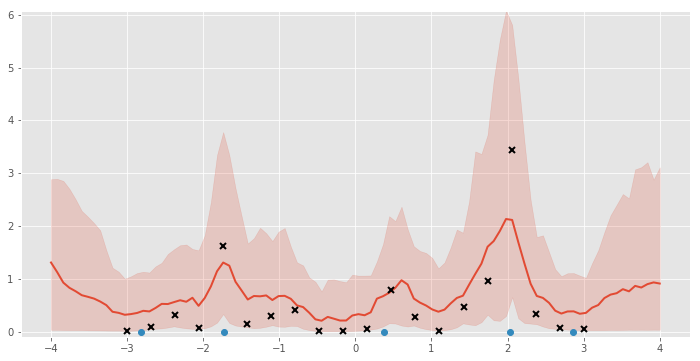

In [74]:
rate_samples = torch.exp(f_samples)
pyplot.figure(figsize=(12, 6))
line, = pyplot.plot(xtest.numpy(), rate_samples.data.mean(0).numpy(), lw=2)
pyplot.fill_between(xtest[:,0], numpy.percentile(rate_samples.data.numpy(), 5, axis=0), numpy.percentile(rate_samples.data.numpy(), 95, axis=0), color=line.get_color(), alpha = 0.2)
pyplot.plot(X.data.numpy(), Y.data.numpy(), 'kx', mew=2)
pyplot.plot(m2.Z.get().data.numpy(),numpy.zeros(m2.num_inducing),'o')
pyplot.ylim(-0.1, numpy.max(numpy.percentile(rate_samples.data.numpy(), 95, axis=0)))